In [80]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
import re
import seaborn as sns
import lxml.html as lx
from lxml import html
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'

# Clean player name

In [81]:
def clean_name(df, colname):
    pat = r'(\,|\'|\.|Jr|Sr|III |IV )'
    df[colname] = df[colname].replace(pat, '', regex=True)    
    df[colname] = df[colname].replace('[^a-zA-Z0-9 ]', '', regex=True)
    return(df)

# Overall rating

In [82]:
def overall(df, values, colname):
    yearly = []
    for year in range(2000,2023):
        newdf = df[df['Year'] == year]
        for i in values:
            newdf.loc[:,i]  = newdf.rank(pct=True)
            if i in {"Int", "Sk", "Fum_RUSH"}:
                newdf[i] = 1-newdf[i]
            
        newdf['avgPercentile'] = newdf[values].mean(axis=1)
        newdf[colname] = newdf['avgPercentile']
        newdf.loc[:,colname]  = newdf.rank(pct=True)
        yearly.append(newdf)
    
    final_df = pd.concat(yearly)
    return(final_df)

# Team Name Abbreviations

In [83]:
nfl_team_name = pd.read_csv('nfl_teams.csv')
names = nfl_team_name.drop(['ID', 'Conference', 'Division'], axis = 1)
abbrv = dict(names.values)

abbrv.update({'Green Bay Packers': 'GNB', 'Kansas City Chiefs': 'KAN', 'New England Patriots':'NWE', 
             'New Orleans Saints':'NOR', 'Las Vegas Raiders':'LVR', 'San Francisco 49ers':'SFO',
             'Tampa Bay Buccaneers':'TAM'})

abbrv['San Diego Chargers'] = 'LAC'
abbrv['Oakland Raiders'] = 'LVR'
abbrv['Washington Redskins'] = 'WAS'
abbrv['Washington Football Team'] = 'WAS'
abbrv['St. Louis Rams'] = 'LAR'
abbrv['St Louis Rams'] = 'LAR'

# Columns to numeric

In [84]:
def cols_to_numeric(df, lst):
    cols=[i for i in df.columns if i not in lst]
    for col in cols:
        df[col]=pd.to_numeric(df[col])


# %Played

In [85]:
def pct_played(df):
    conditions = [df['Year'] <= 2020, df['Year'] > 2020]
    choices = [df['GS']/16, df['GS']/17]
    df["%played"] = np.select(conditions, choices, default=np.nan)
    return(df)

# Scrape stats

In [86]:
def scrape_stats(yearstart, yearend, folder, id_):
    
    df = []
    check = folder
    for year in range(yearstart,yearend):
        with open("{}/{}.html".format(folder,year)) as f:
            page = f.read()

        soup = bs(page, 'html.parser')
        soup.find('tr', class_ = 'thead').decompose()
        if folder == 'rushingstats':
            soup.find('tr', class_ = 'over_header').decompose()
        table = soup.find('table', id = id_)
        if folder == 'defense':
            table_stats = pd.read_html(str(table),header=1)[0]
        else:
            table_stats = pd.read_html(str(table))[0]
        table_stats['Year'] = year
        df.append(table_stats)
    final_df = pd.concat(df)
    return(final_df)

In [87]:
def map_abbrv(df):
    df['Tm'] = np.where(df.Tm == 'OAK', 'LVR', df.Tm)
    df['Tm'] = np.where(df.Tm == 'SDG', 'LAC', df.Tm)
    df['Tm'] = np.where(df.Tm == 'STL', 'LAR', df.Tm)
    return(df)

# Passing stats

In [88]:
passing = scrape_stats(2000,2023, 'passingstats', 'passing')
passing.drop('Rk', axis = 1, inplace = True)
passing.head(2)

,Player,Tm,Age,Pos,G,GS,QBrec,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,1D,Lng,Y/A,AY/A,Y/C,Y/G,Rate,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD,Year,QBR
0,Peyton Manning*,IND,24,QB,16,16,10-6-0,357,571,62.5,4413,33,5.8,15,2.6,213,78,7.7,7.7,12.4,275.8,94.7,20,131,3.4,7.25,7.22,2,3,2000,NaN
1,Jeff Garcia*,SFO,30,QB,16,16,6-10-0,355,561,63.3,4278,31,5.5,10,1.8,206,69,7.6,7.9,12.1,267.4,97.6,24,155,4.1,7.05,7.34,NaN,NaN,2000,NaN


In [89]:
passing.rename(columns={'Yds.1' : 'SkYds'}, inplace = True)
passing = passing.loc[~(passing['Player'] == 'Player')]

passing[['Wins', 'Losses', 'Ties']] = passing['QBrec'].str.split('-', expand = True)
passing = passing.loc[(passing['Pos'] == 'QB')]

passing.drop(['QBrec', 'Ties'], axis =1, inplace = True) 
passing.head()

,Player,Tm,Age,Pos,G,GS,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,1D,Lng,Y/A,AY/A,Y/C,Y/G,Rate,Sk,SkYds,Sk%,NY/A,ANY/A,4QC,GWD,Year,QBR,Wins,Losses
0,Peyton Manning*,IND,24,QB,16,16,357,571,62.5,4413,33,5.8,15,2.6,213,78,7.7,7.7,12.4,275.8,94.7,20,131,3.4,7.25,7.22,2,3,2000,NaN,10,6
1,Jeff Garcia*,SFO,30,QB,16,16,355,561,63.3,4278,31,5.5,10,1.8,206,69,7.6,7.9,12.1,267.4,97.6,24,155,4.1,7.05,7.34,NaN,NaN,2000,NaN,6,10
2,Elvis Grbac*,KAN,30,QB,15,15,326,547,59.6,4169,28,5.1,14,2.6,197,81,7.6,7.5,12.8,277.9,89.9,29,213,5.0,6.87,6.75,3,3,2000,NaN,7,8
3,Daunte Culpepper*,MIN,23,QB,16,16,297,474,62.7,3937,33,7.0,16,3.4,188,78,8.3,8.2,13.3,246.1,98.0,34,181,6.7,7.39,7.28,3,4,2000,NaN,11,5
4,Brett Favre,GNB,31,QB,16,16,338,580,58.3,3812,20,3.4,16,2.8,194,67,6.6,6.0,11.3,238.3,78.0,33,236,5.4,5.83,5.31,0,4,2000,NaN,9,7


In [90]:
cols_to_numeric(passing, ["Player", "Pos", "Tm"])
passing = pct_played(passing)

passing['Cmp%'] = (passing['Cmp'] / passing['Att']) *100
passing = clean_name(passing, 'Player')
passing.sort_values('Yds',ascending = False).reset_index(drop=True).head(10)

,Player,Tm,Age,Pos,G,GS,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,1D,Lng,Y/A,AY/A,Y/C,Y/G,Rate,Sk,SkYds,Sk%,NY/A,ANY/A,4QC,GWD,Year,QBR,Wins,Losses,%played
0,Peyton Manning,DEN,37,QB,16,16,450,659,68.285281,5477,55,8.3,10,1.5,291,78,8.3,9.3,12.2,342.3,115.1,18,120,2.7,7.91,8.87,2.0,2.0,2013,79.0,13.0,3.0,1.0
1,Drew Brees,NOR,32,QB,16,16,468,657,71.232877,5476,46,7.0,14,2.1,279,79,8.3,8.8,11.7,342.3,110.6,24,158,3.5,7.81,8.23,3.0,4.0,2011,82.3,13.0,3.0,1.0
2,Tom Brady,TAM,44,QB,17,17,485,719,67.454798,5316,43,6.0,12,1.7,297,62,7.4,7.8,11.0,312.7,102.1,22,144,3.0,6.98,7.41,3.0,5.0,2021,68.1,13.0,4.0,1.0
3,Patrick Mahomes,KAN,27,QB,17,17,435,648,67.129630,5250,41,6.3,12,1.9,272,67,8.1,8.5,12.1,308.8,105.2,26,188,3.9,7.51,7.93,4.0,4.0,2022,77.6,14.0,3.0,1.0
4,Tom Brady,NWE,34,QB,16,16,401,611,65.630115,5235,39,6.4,12,2.0,262,99,8.6,9.0,13.1,327.2,105.6,32,173,5.0,7.87,8.25,1.0,2.0,2011,73.8,13.0,3.0,1.0
5,Drew Brees,NOR,37,QB,16,16,471,673,69.985141,5208,37,5.5,15,2.2,265,98,7.7,7.8,11.1,325.5,101.7,27,184,3.9,7.18,7.27,2.0,4.0,2016,66.8,7.0,9.0,1.0
6,Drew Brees,NOR,33,QB,16,16,422,670,62.985075,5177,43,6.4,19,2.8,266,80,7.7,7.7,12.3,323.6,96.3,26,190,3.7,7.17,7.17,1.0,2.0,2012,68.7,7.0,9.0,1.0
7,Drew Brees,NOR,34,QB,16,16,446,650,68.615385,5162,39,6.0,12,1.8,246,76,7.9,8.3,11.6,322.6,104.7,37,244,5.4,7.16,7.51,2.0,2.0,2013,69.1,11.0,5.0,1.0
8,Ben Roethlisberger,PIT,36,QB,16,16,452,675,66.962963,5129,34,5.0,16,2.4,248,97,7.6,7.5,11.3,320.6,96.5,24,166,3.4,7.10,7.04,2.0,3.0,2018,69.6,9.0,6.0,1.0
9,Jameis Winston,TAM,25,QB,16,16,380,626,60.702875,5109,33,5.3,30,4.8,243,71,8.2,7.1,13.4,319.3,84.3,47,282,7.0,7.17,6.15,2.0,2.0,2019,55.7,7.0,9.0,1.0


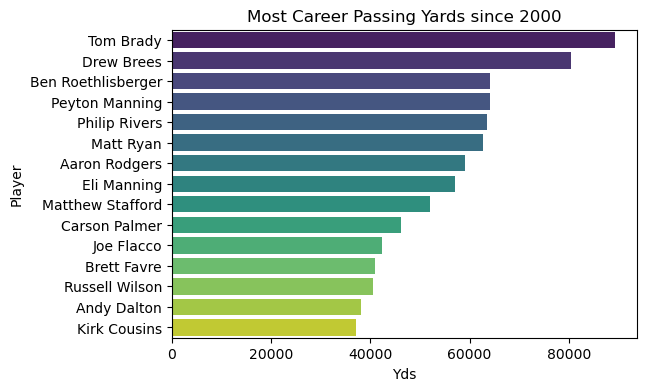

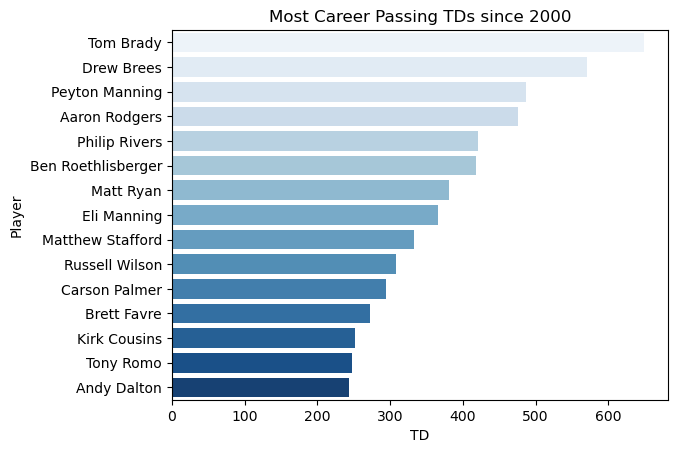

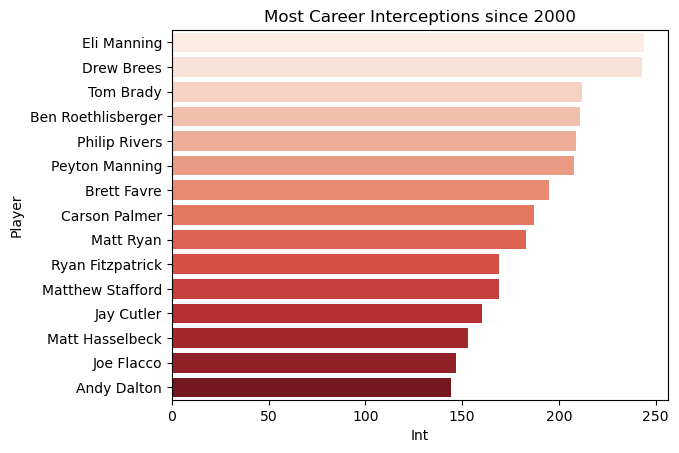

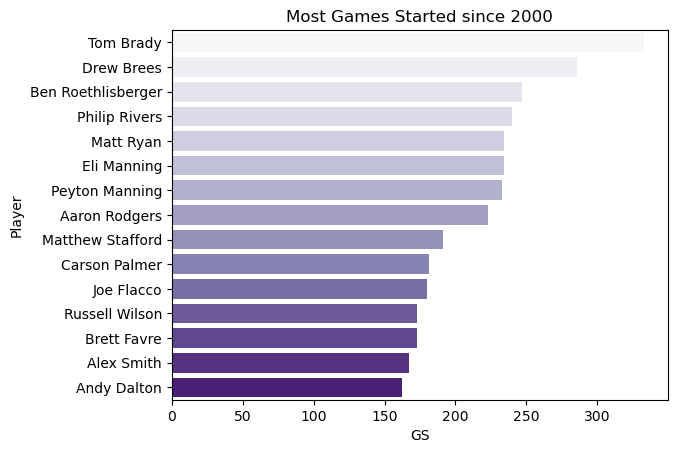

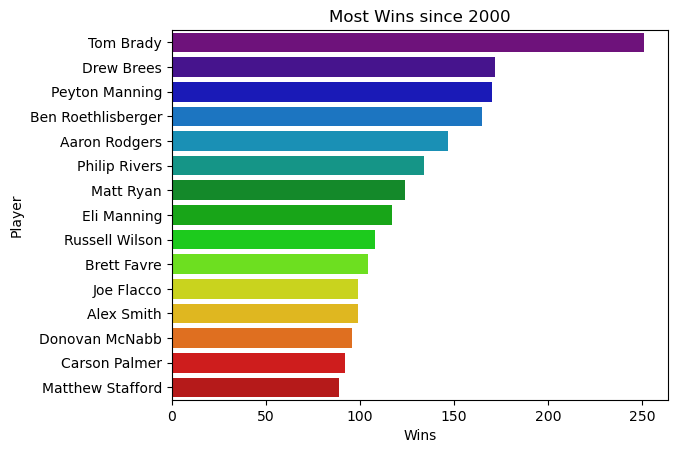

In [91]:
plt.figure(figsize = (6,4))
ax = sns.barplot(data=passing.groupby(['Player'], as_index=False)['Yds'].sum().sort_values('Yds',ascending = False).head(15), 
                 x = 'Yds', y = 'Player', palette = 'viridis')
ax.set(title = 'Most Career Passing Yards since 2000')
plt.show()


ax = sns.barplot(data=passing.groupby(['Player'], as_index=False)['TD'].sum().sort_values('TD',ascending = False).head(15), 
                 x = 'TD', y = 'Player', palette = 'Blues')
ax.set(title = 'Most Career Passing TDs since 2000')
plt.show()

ax = sns.barplot(data=passing.groupby(['Player'], as_index=False)['Int'].sum().sort_values('Int',ascending = False).head(15), 
                 x = 'Int', y = 'Player', palette = 'Reds')
ax.set(title = 'Most Career Interceptions since 2000')
plt.show()

ax = sns.barplot(data=passing.groupby(['Player'], as_index=False)['GS'].sum().sort_values('GS',ascending = False).head(15), 
                 x = 'GS', y = 'Player', palette = 'Purples')
ax.set(title = 'Most Games Started since 2000')
plt.show()

ax = sns.barplot(data=passing.groupby(['Player'], as_index=False)['Wins'].sum().sort_values('Wins',ascending = False).head(15), 
                 x = 'Wins', y = 'Player', palette = 'nipy_spectral')
ax.set(title = 'Most Wins since 2000')
plt.show()

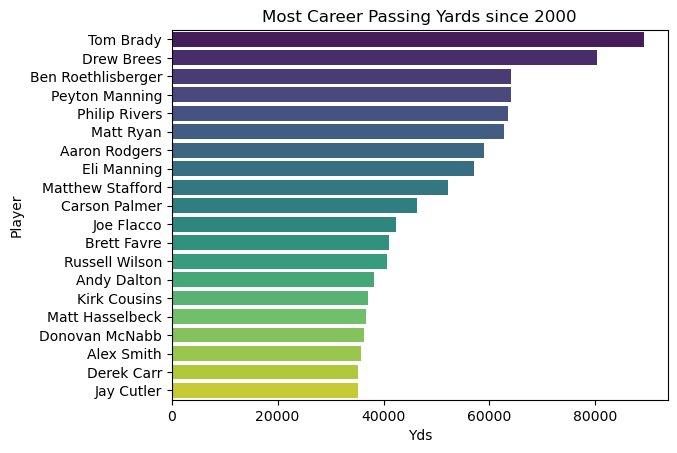

In [92]:
ax = sns.barplot(data=passing.groupby(['Player'], as_index=False)['Yds'].sum().sort_values('Yds',ascending = False).head(20), 
                 x = 'Yds', y = 'Player', palette = 'viridis')
ax.set(title = 'Most Career Passing Yards since 2000')
plt.show()

# Rushing DF

In [93]:
rushing = scrape_stats(2000,2023,'rushingstats','rushing')
rushing.drop('Rk', axis = 1, inplace = True)
rushing.head(2)

,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,Lng,Y/A,Y/G,Fmb,Year
0,Eddie George*+,TEN,27,RB,16,16,403,1509,14,78,35,3.7,94.3,5,2000
1,Edgerrin James*,IND,22,RB,16,16,387,1709,13,100,30,4.4,106.8,5,2000


In [94]:
rushing = rushing.loc[~(rushing['Player'] == 'Player'),:]
rushing['Player'] = np.where((rushing['Player'] == 'Adrian Peterson') & (rushing['Year'] < 2007), 'Adrian N Peterson', rushing['Player'])
rushing.reset_index(drop=True, inplace = True)

In [95]:
cols_to_numeric(rushing, ["Player", "Pos", "Tm"])
rushing = pct_played(rushing)

rush_colnames = [f"{col}_RUSH" for col in rushing.columns]
rushing.columns = rush_colnames
rushing.rename(columns = {'Player_RUSH':'Player', 'Year_RUSH':'Year', 'Pos_RUSH':'Pos', 'Tm_RUSH':'Tm', 'Age_RUSH':'Age' ,'%played_RUSH':'%played',
                         'G_RUSH':'G', 'GS_RUSH':'GS'}, inplace = True)

rushing = clean_name(rushing, 'Player')
rushing.head()

,Player,Tm,Age,Pos,G,GS,Att_RUSH,Yds_RUSH,TD_RUSH,1D_RUSH,Lng_RUSH,Y/A_RUSH,Y/G_RUSH,Fmb_RUSH,Year,%played
0,Eddie George,TEN,27,RB,16,16,403,1509,14,78,35,3.7,94.3,5,2000,1.0000
1,Edgerrin James,IND,22,RB,16,16,387,1709,13,100,30,4.4,106.8,5,2000,1.0000
2,Jerome Bettis,PIT,28,RB,16,16,355,1341,8,72,30,3.8,83.8,1,2000,1.0000
3,James Stewart,DET,29,RB,16,16,339,1184,10,66,34,3.5,74.0,4,2000,1.0000
4,Stephen Davis,WAS,26,RB,15,15,332,1318,11,72,50,4.0,87.9,4,2000,0.9375


# Receiving Stats

In [96]:
receiving = scrape_stats(2000,2023,'receivingstats','receiving')
receiving.drop(['Rk', '1D'], axis = 1, inplace = True)
receiving.head(2)

,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,Lng,Y/Tgt,R/G,Y/G,Fmb,Year
0,Marvin Harrison*,IND,28,WR,16,16,169,102,60.4%,1413,13.9,14,78,8.4,6.4,88.3,2,2000
1,Muhsin Muhammad,CAR,27,WR,16,16,156,102,65.4%,1183,11.6,6,36,7.6,6.4,73.9,1,2000


In [97]:
receiving['Ctch%'] = receiving['Ctch%'].replace('\%', '', regex=True)
receiving = receiving.loc[~(receiving['Player'] == 'Player'),:]

cols_to_numeric(receiving, ["Player", "Pos", "Tm"])
receiving = pct_played(receiving)

rec_colnames = [f"{col}_REC" for col in receiving.columns]
receiving.columns = rec_colnames
receiving.rename(columns = {'Player_REC':'Player', 'Year_REC':'Year', 'Pos_REC':'Pos', 'Tm_REC':'Tm', 'Age_REC':'Age' ,'%played_REC':'%played',
                         'G_REC':'G', 'GS_REC':'GS'}, inplace = True)

receiving = clean_name(receiving, 'Player')
receiving.head()

,Player,Tm,Age,Pos,G,GS,Tgt_REC,Rec_REC,Ctch%_REC,Yds_REC,Y/R_REC,TD_REC,Lng_REC,Y/Tgt_REC,R/G_REC,Y/G_REC,Fmb_REC,Year,%played
0,Marvin Harrison,IND,28,WR,16,16,169.0,102,60.4,1413,13.9,14,78,8.4,6.4,88.3,2.0,2000,1.0000
1,Muhsin Muhammad,CAR,27,WR,16,16,156.0,102,65.4,1183,11.6,6,36,7.6,6.4,73.9,1.0,2000,1.0000
2,Ed McCaffrey,DEN,32,WR,16,16,149.0,101,67.8,1317,13.0,9,61,8.8,6.3,82.3,0.0,2000,1.0000
3,Rod Smith,DEN,30,WR,16,16,173.0,100,57.8,1602,16.0,8,49,9.3,6.3,100.1,1.0,2000,1.0000
4,Terrell Owens,SFO,27,WR,14,13,146.0,97,66.4,1451,15.0,13,69,9.9,6.9,103.6,3.0,2000,0.8125


# Defense

In [98]:
defense = scrape_stats(2000,2023,'defense', 'team_stats')
defense.drop(['Rk', 'G', 'Ply', 'Cmp', 'Att', 'NY/A', 'Y/P', 'FL', 'Yds.1', 'Int', '1stD.1', 'Att.1', 'Yds.2', '1stD.2'], axis = 1, inplace = True)

defense.rename(columns = {'TD':'Passing_TD', 'TD.1':'Rushing_TD', 'Yds.3':'Penalty_Yds', 'Y/A':'Rushing_Y/A'}, inplace=True)
defense['Tm'] = defense['Tm'].map(abbrv)
defense = defense[(defense['PA'].str.isnumeric()) & (~(defense['Tm'].isna()))]
cols_to_numeric(defense, ["Tm"])    
defense['1stD'] = defense['1stD'] - defense['1stPy']
defense.head()

,Tm,PA,Yds,TO,1stD,Passing_TD,Rushing_TD,Rushing_Y/A,Pen,Penalty_Yds,1stPy,Sc%,TO%,EXP,Year
0,BAL,165,3967,49,194,11,5,2.7,84,535,22,15.5,23.7,431.92,2000
1,TEN,191,3813,30,196,10,7,3.6,97,778,19,18.1,13.8,286.03,2000
2,MIA,226,4636,41,248,13,9,4.2,86,793,41,22.8,19.7,224.91,2000
3,PHI,245,4820,31,264,11,10,4.0,111,936,31,25.1,14.9,222.88,2000
4,NYG,246,4546,31,243,23,7,3.2,80,728,31,22.6,15.3,266.17,2000


# Merging QB and rushing dataframe

In [99]:
qbdf = pd.merge(rushing, passing, how='outer', on = ['Player', 'Tm', 'Age', 'Pos', 'Year', 'G', 'GS', '%played'])
qbdf = qbdf[qbdf['Pos'] == 'QB']
qbdf.fillna(0, inplace = True)

### Combining rushing and passing stats for QB since some QBs are known for their rushing ability

In [100]:
qbdf['Total_Att'] = qbdf['Att_RUSH'] + qbdf['Att']
qbdf['Total_1D'] =  (qbdf['1D_RUSH'] + qbdf['1D']) 
qbdf['Total_Yds'] =  qbdf['Yds_RUSH'] + qbdf['Yds']
qbdf['Total_TD'] =  (qbdf['TD_RUSH'] + qbdf['TD']) 


In [101]:
qbdf.drop(['Att_RUSH', 'Att', '1D_RUSH', 
           '1D', 'Y/G_RUSH', 'Y/G', 'Lng_RUSH', 
           'Y/A_RUSH', 'Yds_RUSH', 'TD_RUSH', 'Yds', 'TD'], axis =1, inplace = True)
qbdf

,Player,Tm,Age,Pos,G,GS,Fmb_RUSH,Year,%played,Cmp,Cmp%,TD%,Int,Int%,Lng,Y/A,AY/A,Y/C,Rate,Sk,SkYds,Sk%,NY/A,ANY/A,4QC,GWD,QBR,Wins,Losses,Total_Att,Total_1D,Total_Yds,Total_TD
41,Daunte Culpepper,MIN,23,QB,16,16,11.0,2000,1.000000,297.0,62.658228,7.0,16.0,3.4,78.0,8.3,8.2,13.3,98.0,34.0,181.0,6.7,7.39,7.28,3.0,4.0,0.0,11.0,5.0,563.0,224.0,4407.0,40.0
42,Rich Gannon,OAK,35,QB,16,16,9.0,2000,1.000000,284.0,60.042283,5.9,11.0,2.3,84.0,7.3,7.4,12.1,92.4,28.0,124.0,5.6,6.60,6.73,3.0,4.0,0.0,12.0,4.0,562.0,212.0,3959.0,32.0
44,Donovan McNabb,PHI,24,QB,16,16,7.0,2000,1.000000,330.0,57.996485,3.7,13.0,2.3,70.0,5.9,5.6,10.2,77.8,45.0,262.0,7.3,5.05,4.79,2.0,3.0,0.0,11.0,5.0,655.0,213.0,3994.0,27.0
47,Kordell Stewart,PIT,28,QB,16,11,8.0,2000,0.687500,151.0,52.249135,3.8,8.0,2.8,45.0,6.4,6.0,12.3,73.6,30.0,150.0,9.4,5.36,4.92,1.0,1.0,0.0,7.0,4.0,367.0,120.0,2296.0,18.0
51,Shaun King,TAM,23,QB,16,16,4.0,2000,1.000000,233.0,54.439252,4.2,13.0,3.0,75.0,6.5,5.9,11.9,75.8,37.0,240.0,8.0,5.44,4.95,3.0,3.0,0.0,10.0,6.0,501.0,167.0,3122.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,Brett Rypien,DEN,25,QB,1,0,0.0,2021,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.6,0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.1,0.0,0.0,2.0,0.0,0.0,0.0
7604,Jacob Eason,CAR,25,QB,1,0,0.0,2022,0.000000,3.0,60.000000,0.0,1.0,20.0,49.0,11.8,2.8,19.7,61.7,0.0,0.0,0.0,11.80,2.80,0.0,0.0,0.8,0.0,0.0,5.0,2.0,59.0,0.0
7605,Brian Hoyer,NWE,37,QB,1,1,0.0,2022,0.058824,5.0,83.333333,0.0,0.0,0.0,27.0,6.2,6.2,7.4,92.4,1.0,8.0,14.3,4.14,4.14,0.0,0.0,26.6,0.0,1.0,6.0,2.0,37.0,0.0
7606,Blaine Gabbert,TAM,33,QB,1,0,0.0,2022,0.000000,6.0,75.000000,12.5,0.0,0.0,13.0,3.6,6.1,4.8,119.3,0.0,0.0,0.0,3.63,6.13,0.0,0.0,57.8,0.0,0.0,8.0,2.0,29.0,1.0


# Finding overall rating for QB

In [102]:
test = qbdf.copy()

values = ['Fmb_RUSH', '%played', 'Cmp%', 'Int', 'Y/C', 'Rate', 'Sk', 'ANY/A', 'Wins', 'Total_1D', 'Total_Yds', 'Total_TD', 'GWD']
final_qbdf = overall(test,values, 'QBOverall')
ex = final_qbdf[['Player', 'Tm', 'Pos', 'Year', 'QBOverall']]
ex = map_abbrv(ex)
ex[ex['Year'] == 2022].sort_values('QBOverall',ascending=False).head(10)


,Player,Tm,Pos,Year,QBOverall
7197,Patrick Mahomes,KAN,QB,2022,1.000000
7156,Jalen Hurts,PHI,QB,2022,0.987805
7235,Jared Goff,DET,QB,2022,0.975610
7162,Josh Allen,BUF,QB,2022,0.963415
7185,Joe Burrow,CIN,QB,2022,0.951220
7251,Tua Tagovailoa,MIA,QB,2022,0.939024
7193,Geno Smith,SEA,QB,2022,0.926829
7202,Justin Herbert,LAC,QB,2022,0.914634
7196,Trevor Lawrence,JAX,QB,2022,0.902439
7234,Tom Brady,TAM,QB,2022,0.890244


# Merging rushing and receiving dataframes 

In [103]:
rush_rec = pd.merge(rushing, receiving, how='outer', on = ['Player', 'Tm', 'Age', 'Pos', 'Year', 'G', 'GS', '%played'])
rush_rec.drop('Fmb_REC', axis = 1, inplace = True)
rush_rec.fillna(0,inplace=True)

rush_rec


,Player,Tm,Age,Pos,G,GS,Att_RUSH,Yds_RUSH,TD_RUSH,1D_RUSH,Lng_RUSH,Y/A_RUSH,Y/G_RUSH,Fmb_RUSH,Year,%played,Tgt_REC,Rec_REC,Ctch%_REC,Yds_REC,Y/R_REC,TD_REC,Lng_REC,Y/Tgt_REC,R/G_REC,Y/G_REC
0,Eddie George,TEN,27,RB,16,16,403.0,1509.0,14.0,78.0,35.0,3.7,94.3,5.0,2000,1.000000,65.0,50.0,76.9,453.0,9.1,2.0,24.0,7.0,3.1,28.3
1,Edgerrin James,IND,22,RB,16,16,387.0,1709.0,13.0,100.0,30.0,4.4,106.8,5.0,2000,1.000000,87.0,63.0,72.4,594.0,9.4,5.0,60.0,6.8,3.9,37.1
2,Jerome Bettis,PIT,28,RB,16,16,355.0,1341.0,8.0,72.0,30.0,3.8,83.8,1.0,2000,1.000000,19.0,13.0,68.4,97.0,7.5,0.0,25.0,5.1,0.8,6.1
3,James Stewart,DET,29,RB,16,16,339.0,1184.0,10.0,66.0,34.0,3.5,74.0,4.0,2000,1.000000,48.0,32.0,66.7,287.0,9.0,1.0,32.0,6.0,2.0,17.9
4,Stephen Davis,WAS,26,RB,15,15,332.0,1318.0,11.0,72.0,50.0,4.0,87.9,4.0,2000,0.937500,49.0,33.0,67.3,313.0,9.5,0.0,39.0,6.4,2.2,20.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13047,Stanley Morgan,CIN,26,WR,14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13048,Noah Togiai,PHI,25,TE,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13049,Jake Tonges,CHI,23,TE,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13050,James Washington,DAL,26,WR,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
rush_rec['Total_Yds'] = (rush_rec['Yds_RUSH'] + rush_rec['Yds_REC'])
rush_rec['Total_Tds'] = (rush_rec['TD_RUSH'] + rush_rec['TD_REC']) 

#rush_rec['Total_Y/G'] = (rush_rec['Yds_RUSH'] + rush_rec['Yds_REC']) / rush_rec['G']
# rush_rec['Total_Td/G'] = (rush_rec['TD_RUSH'] + rush_rec['TD_REC']) / rush_rec['G']
# rush_rec['1D/G'] = rush_rec['1D_RUSH'] / rush_rec['G']
rush_rec.drop(['Yds_RUSH', 'Yds_REC', 'TD_RUSH', 'TD_REC'], axis =1, inplace = True)

rbs = rush_rec[rush_rec['Pos'] == 'RB']
#rbs['FUM/Att'] = rbs['Fmb_RUSH'] / rbs['Att_RUSH']

wrs = rush_rec[(rush_rec['Pos'] == 'WR') | (rush_rec['Pos'] == 'TE')]
#wrs['FUM/Rec'] = wrs['Fmb_RUSH'] / wrs['Rec_REC']
#wrs['Target/G'] = wrs['Tgt_REC'] / wrs['G']
rbs

,Player,Tm,Age,Pos,G,GS,Att_RUSH,1D_RUSH,Lng_RUSH,Y/A_RUSH,Y/G_RUSH,Fmb_RUSH,Year,%played,Tgt_REC,Rec_REC,Ctch%_REC,Y/R_REC,Lng_REC,Y/Tgt_REC,R/G_REC,Y/G_REC,Total_Yds,Total_Tds
0,Eddie George,TEN,27,RB,16,16,403.0,78.0,35.0,3.7,94.3,5.0,2000,1.000000,65.0,50.0,76.9,9.1,24.0,7.0,3.1,28.3,1962.0,16.0
1,Edgerrin James,IND,22,RB,16,16,387.0,100.0,30.0,4.4,106.8,5.0,2000,1.000000,87.0,63.0,72.4,9.4,60.0,6.8,3.9,37.1,2303.0,18.0
2,Jerome Bettis,PIT,28,RB,16,16,355.0,72.0,30.0,3.8,83.8,1.0,2000,1.000000,19.0,13.0,68.4,7.5,25.0,5.1,0.8,6.1,1438.0,8.0
3,James Stewart,DET,29,RB,16,16,339.0,66.0,34.0,3.5,74.0,4.0,2000,1.000000,48.0,32.0,66.7,9.0,32.0,6.0,2.0,17.9,1471.0,11.0
4,Stephen Davis,WAS,26,RB,15,15,332.0,72.0,50.0,4.0,87.9,4.0,2000,0.937500,49.0,33.0,67.3,9.5,39.0,6.4,2.2,20.9,1631.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12545,Taiwan Jones,BUF,32,RB,13,0,0.0,0.0,0.0,0.0,0.0,0.0,2020,0.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12698,Rodney Smith,CAR,25,RB,2,0,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.000000,5.0,5.0,100.0,9.6,17.0,9.6,2.5,24.0,48.0,0.0
12761,Nick Bawden,NYJ,25,RB,9,1,0.0,0.0,0.0,0.0,0.0,0.0,2021,0.058824,1.0,1.0,100.0,20.0,20.0,20.0,0.1,2.2,20.0,0.0
12980,Chris Evans,CIN,25,RB,12,0,0.0,0.0,0.0,0.0,0.0,0.0,2022,0.000000,4.0,3.0,75.0,12.7,26.0,9.5,0.3,3.2,38.0,1.0


# RB overalls

In [105]:
# rbs.drop(['Lng_RUSH', 'Tgt_REC', 'Ctch%_REC', 'Lng_REC', 'Y/Tgt_REC'], axis=1,inplace=True)
# rbs.head()

In [106]:
test_rb = rbs.copy()
values = ['Att_RUSH', '1D_RUSH', 'Y/A_RUSH', 'Fmb_RUSH', '%played', 'Rec_REC', 
          'Total_Yds', 'Total_Tds']
final_rbdf = overall(test_rb,values, 'RBOverall')
ex1 = final_rbdf[['Player', 'Tm', 'Pos', 'Year', 'RBOverall']]
ex1 = map_abbrv(ex1)
ex1[ex1['Year'] == 2022].sort_values('RBOverall',ascending=False).head(10)


,Player,Tm,Pos,Year,RBOverall
7124,Josh Jacobs,LVR,RB,2022,1.000000
7137,Aaron Jones,GNB,RB,2022,0.993007
7123,Derrick Henry,TEN,RB,2022,0.986014
7142,Austin Ekeler,LAC,RB,2022,0.979021
7125,Nick Chubb,CLE,RB,2022,0.968531
7131,Christian McCaffrey,2TM,RB,2022,0.968531
7128,Dalvin Cook,MIN,RB,2022,0.958042
7135,Travis Etienne,JAX,RB,2022,0.951049
7140,Rhamondre Stevenson,NWE,RB,2022,0.944056
7126,Saquon Barkley,NYG,RB,2022,0.937063


# WR overalls

In [107]:
# wrs.drop(['Att_RUSH', 'Lng_RUSH', 'Y/A_RUSH', 'Y/G_RUSH', 'Lng_REC', 'Fmb_RUSH'], axis =1, inplace=True)
wrs

,Player,Tm,Age,Pos,G,GS,Att_RUSH,1D_RUSH,Lng_RUSH,Y/A_RUSH,Y/G_RUSH,Fmb_RUSH,Year,%played,Tgt_REC,Rec_REC,Ctch%_REC,Y/R_REC,Lng_REC,Y/Tgt_REC,R/G_REC,Y/G_REC,Total_Yds,Total_Tds
132,Peter Warrick,CIN,23,WR,16,16,16.0,6.0,77.0,9.3,9.3,2.0,2000,1.000000,126.0,51.0,40.5,11.6,46.0,4.7,3.2,37.0,740.0,6.0
150,James Thrash,WAS,25,WR,16,9,10.0,4.0,34.0,8.2,5.1,1.0,2000,0.562500,74.0,50.0,67.6,13.1,50.0,8.8,3.1,40.8,735.0,2.0
153,Dennis Northcutt,CLE,23,WR,15,8,9.0,1.0,13.0,3.7,2.2,1.0,2000,0.500000,82.0,39.0,47.6,10.8,37.0,5.1,2.6,28.1,455.0,0.0
157,Rocket Ismail,DAL,31,WR,9,9,8.0,3.0,37.0,9.1,8.1,1.0,2000,0.562500,43.0,25.0,58.1,14.0,44.0,8.1,2.8,38.9,423.0,1.0
167,Troy Brown,NWE,29,WR,16,15,6.0,2.0,35.0,7.7,2.9,2.0,2000,0.937500,119.0,83.0,69.7,11.4,44.0,7.9,5.2,59.0,990.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13047,Stanley Morgan,CIN,26,WR,14,0,0.0,0.0,0.0,0.0,0.0,0.0,2022,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13048,Noah Togiai,PHI,25,TE,2,0,0.0,0.0,0.0,0.0,0.0,0.0,2022,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13049,Jake Tonges,CHI,23,TE,4,0,0.0,0.0,0.0,0.0,0.0,0.0,2022,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13050,James Washington,DAL,26,WR,2,0,0.0,0.0,0.0,0.0,0.0,0.0,2022,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
test_wr = wrs.copy()
values = ['Fmb_RUSH', '%played', 'Tgt_REC', 'Rec_REC', 'Ctch%_REC', 'Y/R_REC', 'Y/Tgt_REC','R/G_REC','Y/G_REC','Total_Yds','Total_Tds']
final_wrdf = overall(test_wr,values, 'WROverall')

ex2 = final_wrdf[['Player', 'Tm', 'Pos', 'Year', 'WROverall']]
ex2 = map_abbrv(ex2)
ex2[ex2['Year'] == 2022].sort_values('WROverall',ascending=False).head(10)



,Player,Tm,Pos,Year,WROverall
7324,Tyreek Hill,MIA,WR,2022,1.000000
7454,Stefon Diggs,BUF,WR,2022,0.997024
7400,Jaylen Waddle,MIA,WR,2022,0.994048
7422,Travis Kelce,KAN,TE,2022,0.991071
7368,Justin Jefferson,MIN,WR,2022,0.988095
7327,Terry McLaurin,WAS,WR,2022,0.985119
7382,Davante Adams,LVR,WR,2022,0.982143
7402,Brandon Aiyuk,SFO,WR,2022,0.979167
12816,AJ Brown,PHI,WR,2022,0.976190
7352,Christian Kirk,JAX,WR,2022,0.973214


# Defense Overall

In [109]:
values = ['PA', 'Yds', 'TO', '1stD', 'Passing_TD', 'Rushing_TD', 'Rushing_Y/A', 'Pen', 'Penalty_Yds', '1stPy', 'Sc%', 'TO%', 'EXP']

yearly = []
for year in range(2000,2023):
    df = defense[defense['Year'] == year]
    for i in values:
        df.loc[:,i]  = df.rank(pct=True)
        if i not in {'TO', 'TO%', 'EXP', 'Tm', 'Year'}:
            df[i] = 1-df[i]

    df['avgPercentile'] = df[values].mean(axis=1)
    df['D_Overall'] = df['avgPercentile']
    df.loc[:,'D_Overall']  = df.rank(pct=True)
    yearly.append(df)

    
    
    
final_defense = pd.concat(yearly)
final_defense = map_abbrv(final_defense)
#final_defense['Year'] = final_defense['Year']+1

final_defense = final_defense[['Tm', 'Year', 'D_Overall']]
final_defense[final_defense['Year'] == 2022].sort_values('D_Overall',ascending=False).head(10)



,Tm,Year,D_Overall
0,SFO,2022,1.000000
1,BUF,2022,0.968750
2,BAL,2022,0.937500
10,NWE,2022,0.906250
4,CIN,2022,0.859375
3,NYJ,2022,0.859375
7,PHI,2022,0.812500
5,DAL,2022,0.781250
6,WAS,2022,0.750000
9,PIT,2022,0.718750


# Find potential overalls for next year

In [72]:
rosters = pd.read_csv('NFLRosters_since2000.csv', index_col=[0])
rosterswr = rosters[rosters['Pos'].isin(['WR','TE'])]
rostersrb = rosters[rosters['Pos'] == 'RB']
rostersqb = rosters[rosters['Pos'] == 'QB']

rosterswr

,Player,Pos,Year,Tm
4,David Boston,WR,2000,ARI
5,Frank Sanders,WR,2000,ARI
6,Terry Hardy,TE,2000,ARI
4,Shawn Jefferson,WR,2000,ATL
5,Terance Mathis,WR,2000,ATL
...,...,...,...,...
6,Darren Fells,TE,2020,HOU
3,Chris Conley,WR,2021,HOU
4,Brandin Cooks,WR,2021,HOU
5,Antony Auclair,TE,2021,HOU


In [428]:
def finish_overalls(df1,df2,position_overall,colname1,colname2):
    df = df1.merge(df2,on=['Player','Tm','Pos','Year'],how='left')

    df[colname1] = df.groupby(['Player','Pos'])[position_overall].shift()
    #chk.rename(columns = {'WROverall':'ThisYrWROverall'},inplace=True)
    #chk['LastYrWROverall'] = chk.groupby(['Player','Pos'])['ThisYrWROverall'].shift(-1)

    df = df.groupby(['Tm','Year'],as_index=False).mean()
    df[colname2] = df.groupby('Tm')[position_overall].shift()
    df[colname1].fillna(df[colname2],inplace=True)
    #df.drop(position_overall,axis=1,inplace=True)
   # df.dropna(inplace=True)
    return(df)

In [433]:
wr_overalls = finish_overalls(rosterswr,ex2,'WROverall','ProjectedWROverall','LastYrWROverall')
rb_overalls = finish_overalls(rostersrb,ex1,'RBOverall','ProjectedRBOverall','LastYrRBOverall')
qb_overalls = finish_overalls(rostersqb,ex,'QBOverall','ProjectedQBOverall','LastYrQBOverall')

In [460]:
thisyr_rb = rb_overalls.drop(['ProjectedRBOverall','LastYrRBOverall'], axis=1)
thisyr_wr = wr_overalls.drop(['ProjectedWROverall','LastYrWROverall'], axis=1)
thisyr_qb = qb_overalls.drop(['ProjectedQBOverall','LastYrQBOverall'], axis=1)

projected_rb = rb_overalls.drop(['RBOverall'], axis=1)
projected_wr = wr_overalls.drop(['WROverall'], axis=1)
projected_qb = qb_overalls.drop(['QBOverall'], axis=1)


In [461]:
thisyr_wr[thisyr_wr['Tm']=='GNB']

,Tm,Year,WROverall
242,GNB,2000,0.743295
243,GNB,2001,0.823681
244,GNB,2002,0.847118
245,GNB,2003,0.762590
246,GNB,2004,0.868203
247,GNB,2005,0.726690
248,GNB,2006,0.700000
249,GNB,2007,0.895105
250,GNB,2008,0.766667
251,GNB,2009,0.821181


In [464]:
thisyear_stats = thisyr_qb.merge(thisyr_wr, how = 'outer', on = ['Year', 'Tm']).merge(thisyr_rb, how = 'outer', on = ['Year', 'Tm']).merge(final_defense, how = 'outer', on = ['Year', 'Tm'])
thisyear_stats = thisyear_stats.loc[~(thisyear_stats['Tm'] == '3TM'),:]
thisyear_stats = thisyear_stats.loc[~(thisyear_stats['Tm'] == '2TM'),:]
#thisyear_stats = thisyear_stats[thisyear_stats['Year'] > 2000]

thisyear_stats.to_csv('thisyear_stats.csv')

thisyear_stats

,Tm,Year,QBOverall,WROverall,RBOverall,D_Overall
0,ARI,2000,0.542169,0.754789,0.859649,0.080645
1,ARI,2001,0.891892,0.705277,0.826923,0.161290
2,ARI,2002,0.486486,0.553571,0.669643,0.062500
3,ARI,2003,0.518987,0.732614,0.710744,0.218750
4,ARI,2004,0.576923,0.742021,0.753968,0.468750
...,...,...,...,...,...,...
697,WAS,2017,0.835616,0.700637,0.719178,0.500000
698,WAS,2018,0.541667,0.694733,0.923077,0.625000
699,WAS,2019,0.471429,0.649265,0.842857,0.265625
700,WAS,2020,0.469136,0.654454,0.886667,0.968750


## Filtering overalls by position, team, year

In [451]:
tm_offense = qb_overalls.merge(qb_overalls, how = 'outer', on = ['Year', 'Tm']).merge(rb_overalls, how = 'outer', on = ['Year', 'Tm']).merge(final_defense, how = 'outer', on = ['Year', 'Tm'])
tm_offense = tm_offense.loc[~(tm_offense['Tm'] == '3TM'),:]
tm_offense = tm_offense.loc[~(tm_offense['Tm'] == '2TM'),:]
tm_offense[tm_offense['Year'] > 2000]
#nfc_standings['Tm'] = np.where(nfc_standings.Tm == 'St. Louis Rams', 'Los Angeles Rams', nfc_standings.Tm)
#nfc_standings['Tm'] = np.where(nfc_standings.Tm == 'Washington Redskins', 'Washington Commanders', nfc_standings.Tm)
#nfc_standings['Tm'] = np.where(nfc_standings.Tm == 'Washington Football Team', 'Washington Commanders', nfc_standings.Tm)



#tm_offense[tm_offense['Year'] == 2022].sort_values('QBOverall', ascending = False)

,Tm,Year,QBOverall,ProjectedQBOverall,LastYrQBOverall,WROverall,ProjectedWROverall,LastYrWROverall,RBOverall,ProjectedRBOverall,LastYrRBOverall,D_Overall
1,ARI,2001,0.891892,0.542169,0.542169,0.705277,0.894636,0.754789,0.826923,0.859649,0.859649,0.161290
2,ARI,2002,0.486486,0.891892,0.891892,0.553571,0.650370,0.705277,0.669643,0.826923,0.826923,0.062500
3,ARI,2003,0.518987,0.513514,0.486486,0.732614,0.582707,0.553571,0.710744,0.669643,0.669643,0.218750
4,ARI,2004,0.576923,0.518987,0.518987,0.742021,0.870504,0.732614,0.753968,0.714286,0.710744,0.468750
5,ARI,2005,0.812500,0.653846,0.576923,0.766608,0.812057,0.742021,0.692308,0.710744,0.753968,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
697,WAS,2017,0.835616,0.957143,0.957143,0.700637,0.785933,0.872324,0.719178,0.725000,0.725000,0.500000
698,WAS,2018,0.541667,0.986301,0.835616,0.694733,0.818585,0.700637,0.923077,0.719178,0.719178,0.625000
699,WAS,2019,0.471429,0.569444,0.541667,0.649265,0.840764,0.694733,0.842857,0.923077,0.923077,0.265625
700,WAS,2020,0.469136,0.541667,0.471429,0.654454,0.713235,0.649265,0.886667,0.842857,0.842857,0.968750


In [452]:
tm_offense['Tm'].unique()

array(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
       'DEN', 'DET', 'GNB', 'HOU', 'IND', 'JAX', 'KAN', 'LAC', 'LAR',
       'LVR', 'MIA', 'MIN', 'NOR', 'NWE', 'NYG', 'NYJ', 'PHI', 'PIT',
       'SEA', 'SFO', 'TAM', 'TEN', 'WAS'], dtype=object)

In [453]:
tm_offense.to_csv('playoff_team_stats.csv')

In [454]:
tm_offense.tail(50)

,Tm,Year,QBOverall,ProjectedQBOverall,LastYrQBOverall,WROverall,ProjectedWROverall,LastYrWROverall,RBOverall,ProjectedRBOverall,LastYrRBOverall,D_Overall
652,TAM,2016,0.785714,0.773333,0.773333,0.532110,0.526205,0.588050,0.771875,0.993671,0.993671,0.562500
653,TAM,2017,0.739726,0.785714,0.785714,0.842357,0.896024,0.532110,0.623288,0.771875,0.771875,0.250000
654,TAM,2018,0.652778,0.739726,0.739726,0.908012,0.866242,0.842357,0.755245,0.623288,0.623288,0.031250
655,TAM,2019,0.742857,0.652778,0.652778,0.814706,0.871144,0.908012,0.885714,0.755245,0.755245,0.531250
656,TAM,2020,0.956790,0.785714,0.742857,0.849856,0.924065,0.814706,0.893333,0.885714,0.885714,0.843750
657,TAM,2021,1.000000,0.956790,0.956790,0.819014,0.861334,0.849856,0.960784,0.914286,0.893333,0.937500
658,TEN,2000,0.831325,NaN,NaN,0.725096,NaN,NaN,0.982456,NaN,NaN,0.967742
659,TEN,2001,0.945946,0.831325,0.831325,0.812741,0.729246,0.725096,0.846154,0.982456,0.982456,0.193548
660,TEN,2002,0.891892,0.945946,0.945946,0.679511,0.812741,0.812741,0.812500,0.846154,0.846154,0.828125
661,TEN,2003,0.962025,0.891892,0.891892,0.858813,0.699248,0.679511,0.785124,0.812500,0.812500,0.843750
